Plot supplementary figures S2, S3, S4. 

In [26]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import os

In [27]:
plt.style.use("stylesheets/supp_stylesheet.mplstyle")
# Remove top and left frame
import matplotlib as mpl

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

# Read data

In [28]:
# Directory to save figures
PLOT_DIR = "supp_figures"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

In [29]:
fpath = "supp_data/quality_appeal.parquet"
data = pd.read_parquet(fpath)

In [30]:
data.head()

,post_id,Score,retweet_count,favorite_count
39,1240613512218632192,87.5,1,None
148,1240613707870359552,72.0,2,None
223,1240613851319721984,82.5,0,None
238,1240613869766225920,80.0,0,None
268,1240613937294585856,95.0,0,None


# Relationship between quality and engagement
Fig.S2: Scatter plot of retweet counts and Newsguard scores of original tweets with links to news articles. The size of each point is proportional to the number of tweets having a given retweet count and Newsguard score. We add one to the retweet count so that the tweets with zero retweets are visible on the log scale. The slightly negative correlation is driven by the majority of tweets linking to high-quality sources and having no retweets.

In [31]:
data.describe()

,Score,retweet_count
count,110224.000000,110224.000000
mean,86.889031,8.281372
std,18.324051,105.854882
min,0.000000,0.000000
25%,82.500000,0.000000
50%,92.500000,0.000000
75%,100.000000,3.000000
max,100.000000,23674.000000


In [32]:
sizes = data.groupby(["Score", "retweet_count"])["post_id"].count().reset_index()
sum_occurrences = sizes["post_id"].sum()
sizes["counter"] = sizes["post_id"].apply(lambda x: x / sum_occurrences)
sizes.drop(columns="post_id", inplace=True)
sizes.head()

,Score,retweet_count,counter
0,0.0,0,0.000281
1,0.0,1,0.000064
2,0.0,2,0.000036
3,0.0,4,0.000009
4,0.0,27,0.000009


In [33]:
new_data = pd.merge(data, sizes, on=["Score", "retweet_count"])
new_data.head()

,post_id,Score,retweet_count,favorite_count,counter
0,1240613512218632192,87.5,1,None,0.018571
1,1241379469266432005,87.5,1,None,0.018571
2,1241380205748510723,87.5,1,None,0.018571
3,1241380432215789568,87.5,1,None,0.018571
4,1241381358078959618,87.5,1,None,0.018571


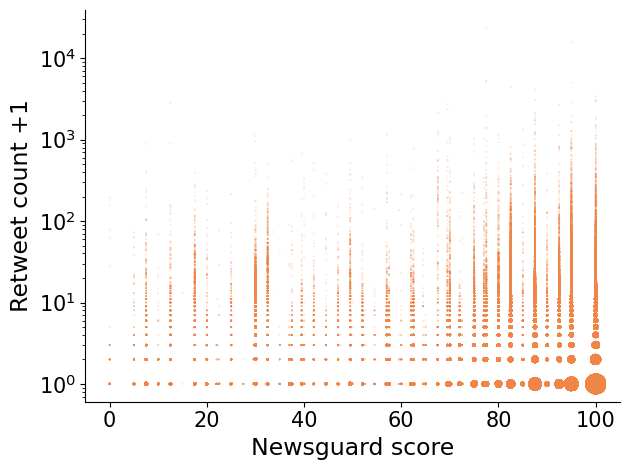

In [34]:
figname = f"{PLOT_DIR}/appeal_vs_quality"
plt.scatter(
    new_data["Score"],
    new_data["retweet_count"] + 1,
    c="#F18447",
    s=new_data["counter"] * 1000,
)
plt.xlabel("Newsguard score")
plt.ylabel("Retweet count +1")
plt.yscale("log")
plt.tight_layout()
plt.savefig(f"{figname}.png")

## Empirical estimation of quality distribution
### Fit data to an exponential distribution

In [35]:
def expon_quality(x, a):
    C = a / (1 - np.e ** (-1 * a))
    return C * np.e ** (-1 * a * x)

In [36]:
max_val = data["Score"].max()
prob_r = dict(sorted(Counter(data["Score"].values).items()))  # k,v are score, count
prob_r = {
    k / max_val: v for (k, v) in prob_r.items()
}  # rescale - k,v are score, probability

In [37]:
data["scaled_score"] = data["Score"].apply(lambda x: x / max_val)

In [38]:
# normalize by area under empirical curve
area = 0
r = list(prob_r.keys())
for i in range(len(r) - 1):
    area += (r[i + 1] - r[i]) * prob_r[r[i + 1]]
prob_r = {
    k: v / area for (k, v) in prob_r.items()
}  # k,v are score, normalized probability

In [39]:
xdata = list(prob_r.keys())
ydata = list(prob_r.values())

In [40]:
popt, pcov = curve_fit(expon_quality, xdata, ydata)
popt, pcov

(array([-10.39734283]), array([[0.39518194]]))

In [41]:
# Data from the fitted  distribution of quality
xx = np.linspace(0, 1, 1000)
yy = expon_quality(xx, popt[0])

### Plot: Quality distribution
Fig.S3: Distribution of quality for authentic agent messages (line) fitted to empirical Twitter data (points).

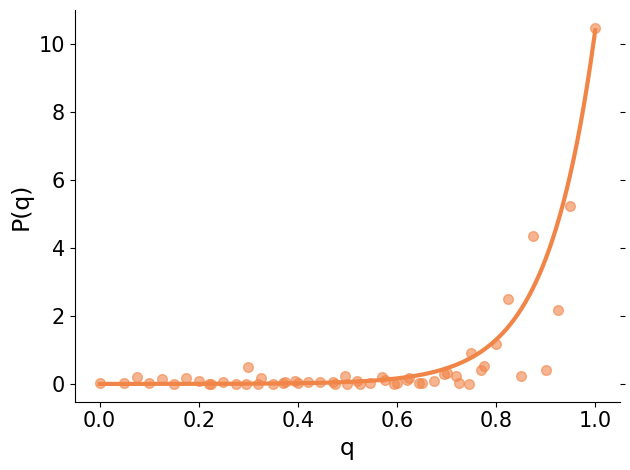

In [42]:
fpath = f"{PLOT_DIR}/quality_func"
fig, ax = plt.subplots()
ax.scatter(xdata, ydata, label="data", color="#F18447", alpha=0.6)
ax.plot(xx, yy, label="model", c="#F18447")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.set_xlabel("q")
ax.set_ylabel("P(q)")

plt.tight_layout()
plt.savefig(f"{fpath}.png")

## Appeal distribution

In [43]:
from simsom.utils import *
import glob

# yellow, orange, pink, purple,  blue, teal,
PALETTE = ["#F8D625", "#F18447", "#BC3684", "#550F6B", "#3863AC", "#209B8A"]

### Plot Appeal PDF
Fig.S4: (a) Distribution of appeal for authentic agent messages, for different values of the parameter $\alpha$

In [44]:
# appeal pdf
def appeal_pdf(x, exp):
    return (1 + exp) * ((1 - x) ** exp)

In [45]:
exps = [1, 4, 10]
xdatas = []  # list of lists
ydatas = []
for exp_val in exps:
    xdata = np.linspace(0, 1, 1000)
    xdatas += [xdata]
    ydatas += [appeal_pdf(xdata, exp=exp_val)]

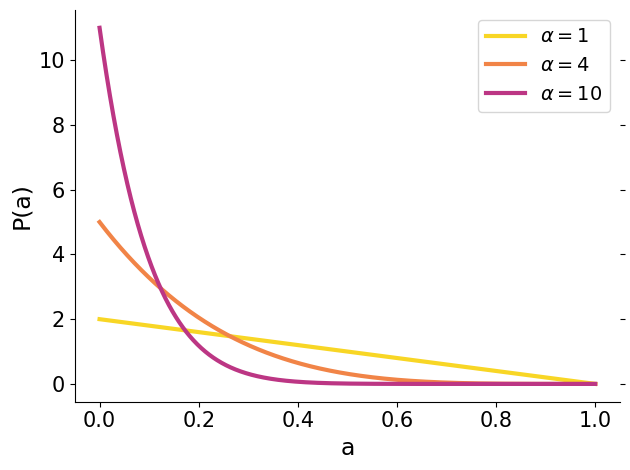

In [46]:
fpath = f"{PLOT_DIR}/model_appeal"

fig, ax = plt.subplots()
for i, expval in enumerate(exps):
    xdata = xdatas[i]
    ydata = ydatas[i]
    ax.plot(xdata, ydata, label=f"$\\alpha={expval}$", color=PALETTE[i])
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
plt.legend()
plt.ylabel("P(a)")
plt.xlabel("a")
plt.tight_layout()
plt.savefig(f"{fpath}.png")

## Compare model vs. empirical reshare count distribution 

Fig. S4(b): Reshare count distribution of messages in the baseline simulation of the model with only authentic accounts, and of empirical posts. The message reshare counts in the model are measured at the steady state.

In [47]:
def get_rt_count(fpath):
    # return an array of retweet count from verbose .json.gz result rt_count to plot ecdf
    data = read_json_compressed(fpath)
    df = pd.DataFrame.from_records(data["all_messages"])
    rt = df.explode("spread_via_agents")
    rt = rt.drop_duplicates(subset=["id", "spread_via_agents"])
    focal = rt.groupby("id")["spread_via_agents"].count().reset_index()
    focal = focal.rename(columns={"spread_via_agents": "rt_count"})
    return focal["rt_count"].values

### Empirical data

In [48]:
empirical = pd.read_parquet("~/infopolluters/simsom/data/quality_appeal.parquet")
empirical.head()

,post_id,Score,retweet_count,favorite_count
39,1240613512218632192,87.5,1,None
148,1240613707870359552,72.0,2,None
223,1240613851319721984,82.5,0,None
238,1240613869766225920,80.0,0,None
268,1240613937294585856,95.0,0,None


### Combine multiple runs
The number of retweets for messages in the simulation is obtained by combining data generated over 10 runs. We cannot provide the data via Github since it is huge. However, it will be available on request

In [49]:
ABS_PATH = "/N/project/simsom/simsom_v3/"
ARCHIVE_PATH = "/N/project/osome_vaccines/playground/baotruon/simsomv3_archive_results"
fpaths = glob.glob(f"{ARCHIVE_PATH}/zl2_11252023/results_verbose/baseline/*.json.gz")
exp2 = []
for fpath in fpaths:
    counts = get_rt_count(fpath)
    exp2 += counts.tolist()
len(exp2)

596071

In [50]:
fpaths = glob.glob(f"{ABS_PATH}/zl5_11252023/results_verbose/baseline/*.json.gz")
exp5 = []
for fpath in fpaths:
    counts = get_rt_count(fpath)
    exp5 += counts.tolist()
len(exp5)

705093

In [51]:
fpaths = glob.glob(f"{ARCHIVE_PATH}/zl11_11252023/results_verbose/baseline/*.json.gz")
exp11 = []
for fpath in fpaths:
    counts = get_rt_count(fpath)
    exp11 += counts.tolist()
len(exp11)

700675

/geode2/home/u015/baotruon/BigRed200/conda/envs/simsommodel/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


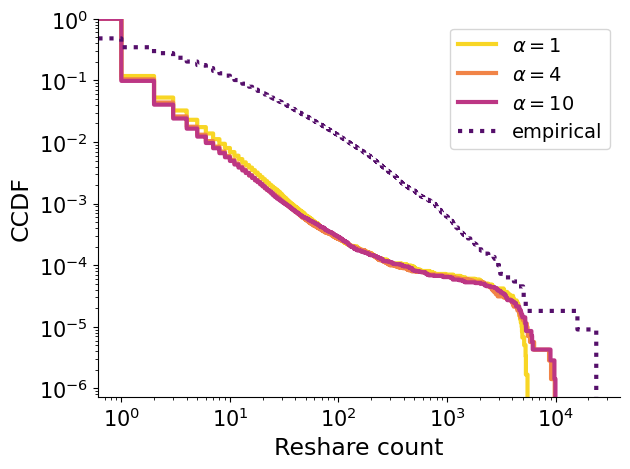

In [54]:
fpath = f"{PLOT_DIR}/rt_count"
data = [exp2, exp5, exp11]
names = ["1", "4", "10"]
for i, (xdata, name) in enumerate(zip(data, names)):
    sns.ecdfplot(
        xdata,
        complementary=True,
        log_scale=(True, True),
        label=f"$\\alpha={name}$",
        color=PALETTE[i],
    )
sns.ecdfplot(
    empirical["retweet_count"],
    complementary=True,
    log_scale=(True, True),
    label="empirical",
    linestyle="dotted",
    color=PALETTE[len(data)],
)

plt.legend()
# plt.title('Retweet count for different appeal distributions')
plt.ylabel("CCDF")
plt.xlabel("Reshare count")
plt.tight_layout()
plt.savefig(f"{fpath}.png")